**Tau->µµµ machine learning basis** *by Louis Duval*

The contest and dataset is available here: https://www.kaggle.com/c/flavours-of-physics/overview/description

kaggle notebook: https://www.kaggle.com/poultfloyd/tau-project/code?scriptVersionId=28998559

In this project I choosed to work on BSM physics. These tau leptons to triple muons decays are said to be impossible in standard model. However it is interresting for rejection (or new physic!) to keep track of these kind of events.
This was originaly a contest made by CERN with more than 15 000€ cashprize and was supported by IFJ.
I investigated some features of machine learning to try to see if some algorithm are more efficient or not.


As datasets are made with both MC simulations and real data, some verifications are necessary:
* Some features can be attached more to MC rather than physics so we have to make sure we are learning on **physics** and not **MC artifacts**.
* Each particle has its own mass. In an ideal world, one would just the mass of a particle to tell which particle it is. However, in reality, mass is an estimation, and it isn't a feature that scientists trust when building a model. Correlations with mass can cause an artificial signal-like mass peak or lead to incorrect background estimations. 

In order to consider having a valid algorithm, the model has to pass some test (which I only adapted for my code, taken from here: https://www.kaggle.com/bdmj12/flavours-of-physics-3-competition-2 ).

We can start with some imports

In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
files_path=[]
files_output=[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        files_path.append(os.path.join(dirname, filename))


        
# Any results you write to the current directory are saved as output.
import csv
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
#from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn import ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import zipfile
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop


/kaggle/input/flavours-of-physics-kernels-only/check_correlation.csv.zip
/kaggle/input/flavours-of-physics-kernels-only/check_agreement.csv.zip
/kaggle/input/flavours-of-physics-kernels-only/training.csv.zip
/kaggle/input/flavours-of-physics-kernels-only/test.csv.zip
/kaggle/input/flavours-of-physics-kernels-only/sample_submission.csv.zip


Here are some helpful functions from https://www.kaggle.com/bdmj12/flavours-of-physics-3-competition-2 to verify if the algorith passes the correlation and the agreement test

In [14]:
### THIS CELL IS JUST THE EVALUATION PYTHON FILE 

import numpy
from sklearn.metrics import roc_curve, auc


def __rolling_window(data, window_size):
    """
    Rolling window: take window with definite size through the array

    :param data: array-like
    :param window_size: size
    :return: the sequence of windows

    Example: data = array(1, 2, 3, 4, 5, 6), window_size = 4
        Then this function return array(array(1, 2, 3, 4), array(2, 3, 4, 5), array(3, 4, 5, 6))
    """
    shape = data.shape[:-1] + (data.shape[-1] - window_size + 1, window_size)
    strides = data.strides + (data.strides[-1],)
    return numpy.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)


def __cvm(subindices, total_events):
    """
    Compute Cramer-von Mises metric.
    Compared two distributions, where first is subset of second one.
    Assuming that second is ordered by ascending

    :param subindices: indices of events which will be associated with the first distribution
    :param total_events: count of events in the second distribution
    :return: cvm metric
    """
    target_distribution = numpy.arange(1, total_events + 1, dtype='float') / total_events
    subarray_distribution = numpy.cumsum(numpy.bincount(subindices, minlength=total_events), dtype='float')
    subarray_distribution /= 1.0 * subarray_distribution[-1]
    return numpy.mean((target_distribution - subarray_distribution) ** 2)


def compute_cvm(predictions, masses, n_neighbours=200, step=50):
    """
    Computing Cramer-von Mises (cvm) metric on background events: take average of cvms calculated for each mass bin.
    In each mass bin global prediction's cdf is compared to prediction's cdf in mass bin.

    :param predictions: array-like, predictions
    :param masses: array-like, in case of Kaggle tau23mu this is reconstructed mass
    :param n_neighbours: count of neighbours for event to define mass bin
    :param step: step through sorted mass-array to define next center of bin
    :return: average cvm value
    """
    predictions = numpy.array(predictions)
    masses = numpy.array(masses)
    assert len(predictions) == len(masses)

    # First, reorder by masses
    predictions = predictions[numpy.argsort(masses)]

    # Second, replace probabilities with order of probability among other events
    predictions = numpy.argsort(numpy.argsort(predictions, kind='mergesort'), kind='mergesort')

    # Now, each window forms a group, and we can compute contribution of each group to CvM
    cvms = []
    for window in __rolling_window(predictions, window_size=n_neighbours)[::step]:
        cvms.append(__cvm(subindices=window, total_events=len(predictions)))
    return numpy.mean(cvms)


def __roc_curve_splitted(data_zero, data_one, sample_weights_zero, sample_weights_one):
    """
    Compute roc curve

    :param data_zero: 0-labeled data
    :param data_one:  1-labeled data
    :param sample_weights_zero: weights for 0-labeled data
    :param sample_weights_one:  weights for 1-labeled data
    :return: roc curve
    """
    labels = [0] * len(data_zero) + [1] * len(data_one)
    weights = numpy.concatenate([sample_weights_zero, sample_weights_one])
    data_all = numpy.concatenate([data_zero, data_one])
    fpr, tpr, _ = roc_curve(labels, data_all, sample_weight=weights)
    return fpr, tpr


def compute_ks(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.

    :param data_prediction: array-like, real data predictions
    :param mc_prediction: array-like, Monte Carlo data predictions
    :param weights_data: array-like, real data weights
    :param weights_mc: array-like, Monte Carlo weights
    :return: ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = numpy.array(data_prediction), numpy.array(mc_prediction)
    weights_data, weights_mc = numpy.array(weights_data), numpy.array(weights_mc)

    assert numpy.all(data_prediction >= 0.) and numpy.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert numpy.all(mc_prediction >= 0.) and numpy.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= numpy.sum(weights_data)
    weights_mc /= numpy.sum(weights_mc)

    fpr, tpr = __roc_curve_splitted(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = numpy.max(numpy.abs(fpr - tpr))
    return Dnm

def compute_ks_not_int(data_prediction, mc_prediction, weights_data, weights_mc):
    """
    Compute Kolmogorov-Smirnov (ks) distance between real data predictions cdf and Monte Carlo one.

    :param data_prediction: array-like, real data predictions
    :param mc_prediction: array-like, Monte Carlo data predictions
    :param weights_data: array-like, real data weights
    :param weights_mc: array-like, Monte Carlo weights
    :return: ks value
    """
    assert len(data_prediction) == len(weights_data), 'Data length and weight one must be the same'
    assert len(mc_prediction) == len(weights_mc), 'Data length and weight one must be the same'

    data_prediction, mc_prediction = np.round(numpy.array(data_prediction)).astype(int), numpy.array(mc_prediction)
    weights_data, weights_mc = numpy.array(weights_data), numpy.array(weights_mc)

    for i in range(len(data_prediction)):
        if data_prediction[i]<0:
            data_prediction[i]=0
        if data_prediction[i]>1:
            data_prediction[i]=1
            
    for i in range(len(mc_prediction)):
        if mc_prediction[i]<0:
            mc_prediction[i]=0
        if mc_prediction[i]>1:
            mc_prediction[i]=1
    
    assert numpy.all(data_prediction >= 0.) and numpy.all(data_prediction <= 1.), 'Data predictions are out of range [0, 1]'
    assert numpy.all(mc_prediction >= 0.) and numpy.all(mc_prediction <= 1.), 'MC predictions are out of range [0, 1]'

    weights_data /= numpy.sum(weights_data)
    weights_mc /= numpy.sum(weights_mc)

    fpr, tpr = __roc_curve_splitted(data_prediction, mc_prediction, weights_data, weights_mc)

    Dnm = numpy.max(numpy.abs(fpr - tpr))
    return Dnm



def roc_auc_truncated(labels, predictions, tpr_thresholds=(0.2, 0.4, 0.6, 0.8),
                      roc_weights=(4, 3, 2, 1, 0)):
    """
    Compute weighted area under ROC curve.

    :param labels: array-like, true labels
    :param predictions: array-like, predictions
    :param tpr_thresholds: array-like, true positive rate thresholds delimiting the ROC segments
    :param roc_weights: array-like, weights for true positive rate segments
    :return: weighted AUC
    """
    assert numpy.all(predictions >= 0.) and numpy.all(predictions <= 1.), 'Data predictions are out of range [0, 1]'
    assert len(tpr_thresholds) + 1 == len(roc_weights), 'Incompatible lengths of thresholds and weights'
    fpr, tpr, _ = roc_curve(labels, predictions)
    area = 0.
    tpr_thresholds = [0.] + list(tpr_thresholds) + [1.]
    for index in range(1, len(tpr_thresholds)):
        tpr_cut = numpy.minimum(tpr, tpr_thresholds[index])
        tpr_previous = numpy.minimum(tpr, tpr_thresholds[index - 1])
        area += roc_weights[index - 1] * (auc(fpr, tpr_cut) - auc(fpr, tpr_previous))
    tpr_thresholds = numpy.array(tpr_thresholds)
    # roc auc normalization to be 1 for an ideal classifier
    area /= numpy.sum((tpr_thresholds[1:] - tpr_thresholds[:-1]) * numpy.array(roc_weights))
    return area

def check_corr_test(model,var):

    check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
    correlation_probs = model.predict_proba(check_correlation[var])[:, 1]
    cvm = compute_cvm(correlation_probs, check_correlation['mass'])
    print('CvM metric', cvm, cvm < 0.002)
    return cvm<0.002

def check_corr_test_get_value(model,var):

    check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
    correlation_probs = model.predict_proba(check_correlation[var])[:, 1]
    cvm = compute_cvm(correlation_probs, check_correlation['mass'])
    #print('CvM metric', cvm, cvm < 0.002)
    return cvm


def check_corr_test_GBR(model,var):

    check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
    correlation_probs = model.predict(check_correlation[var])
    cvm = compute_cvm(correlation_probs, check_correlation['mass'])
    print('CvM metric', cvm, cvm < 0.002)
    return cvm<0.002


def check_corr_test_get_value_GBR(model,var):

    check_correlation = pd.read_csv(folder + 'check_correlation.csv', index_col='id')
    correlation_probs = model.predict(check_correlation[var])
    cvm = compute_cvm(correlation_probs, check_correlation['mass'])
    #print('CvM metric', cvm, cvm < 0.002)
    return cvm

def comp_auc(model,var):
    train_eval = train[train['min_ANNmuon'] > 0.4]
    train_probs = model.predict(train_eval[var])
    AUC = roc_auc_truncated(train_eval['signal'], train_probs)
    print('AUC', AUC)
    return AUC

def check_ag_test(model,var):
    check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
    agreement_probs = model.predict(check_agreement[var])
    
    ks = compute_ks(
        agreement_probs[check_agreement['signal'].values == 0],
        agreement_probs[check_agreement['signal'].values == 1],
        check_agreement[check_agreement['signal'] == 0]['weight'].values,
        check_agreement[check_agreement['signal'] == 1]['weight'].values)
    print('KS metric', ks, ks < 0.09)
    return ks<0.09

def check_ag_test_get_value(model,var):
    check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
    agreement_probs = model.predict(check_agreement[var])
    
    ks = compute_ks_not_int(
        agreement_probs[check_agreement['signal'].values == 0],
        agreement_probs[check_agreement['signal'].values == 1],
        check_agreement[check_agreement['signal'] == 0]['weight'].values,
        check_agreement[check_agreement['signal'] == 1]['weight'].values)
    #print('KS metric', ks, ks < 0.09)
    return ks

def check_ag_test_not_int(model,var):
    check_agreement = pd.read_csv(folder + 'check_agreement.csv', index_col='id')
    agreement_probs = model.predict(check_agreement[var])
    
    ks = compute_ks_not_int(
        agreement_probs[check_agreement['signal'].values == 0],
        agreement_probs[check_agreement['signal'].values == 1],
        check_agreement[check_agreement['signal'] == 0]['weight'].values,
        check_agreement[check_agreement['signal'] == 1]['weight'].values)
    print('KS metric', ks, ks < 0.09)
    return ks<0.09


def pred_file(model,var):

    test = pd.read_csv(folder + 'test.csv', index_col='id')
    result = pd.DataFrame({'id': test.index})
    result['prediction'] = model.predict(test[var])
    result.to_csv('prediction %s .csv' % version, index=False, sep=',')
    ## combine tests into one function

def eval(model,var):
    check_ag_test(model,var)
    check_corr_test(model,var)
    comp_auc(model,var)
    
candidate_models = {}   # we'll store candidate models here

def test_model(model):
    #if the model passes the tests...
    if(check_corr_test(model,variables) and check_ag_test(model,variables)):
        #...add it to the candidates
        candidate_models[svc] = comp_auc(model,variables)
        print('passed')
    else:
        print('failed')

We start by extracting the files:

In [15]:
#extract zip files
print(files_path)
files_out='/kaggle/working'
for files in files_path:
    with zipfile.ZipFile(files, 'r') as zip_ref:
        zip_ref.extractall(files_out)


['/kaggle/input/flavours-of-physics-kernels-only/check_correlation.csv.zip', '/kaggle/input/flavours-of-physics-kernels-only/check_agreement.csv.zip', '/kaggle/input/flavours-of-physics-kernels-only/training.csv.zip', '/kaggle/input/flavours-of-physics-kernels-only/test.csv.zip', '/kaggle/input/flavours-of-physics-kernels-only/sample_submission.csv.zip']


We can now open them and have a closer look:

In [16]:
files=[]
file=""
folder="/kaggle/working/"
#extract filenames
for dirname, _, filenames in os.walk(folder):
    files.append(filenames)
files=files[0]
print(files)


#store datas into a dictionnary
#files can be used as an iterator to process everything
contest_data={}
for file in files:
    contest_data[file]=pd.read_csv(folder + file, error_bad_lines=False)
print(contest_data)

['__notebook_source__.ipynb', 'test.csv', 'training.csv', 'check_agreement.csv', 'sample_submission.csv', 'check_correlation.csv']
{'__notebook_source__.ipynb':                                    {
  "cells": []                    NaN
  "metadata": {                  NaN
    "language_info": {           NaN
      "name": "none"             NaN
      "version": "0"             NaN
    }                            NaN
    "kernelspec": {              NaN
      "display_name": "Python 3" NaN
      "language": "python"       NaN
      "name": "python3"          NaN
    }                            NaN
  }                              NaN
  "nbformat": 4                  NaN
  "nbformat_minor": 0            NaN
}                                NaN, 'test.csv':               id  LifeTime      dira  FlightDistance  FlightDistanceError  \
0       14711831  0.001273  0.999816        8.569642             0.310039   
1       16316387  0.000661  0.999954        7.061379             0.348772   
2  

In [17]:
contest_data

{'__notebook_source__.ipynb':                                    {
   "cells": []                    NaN
   "metadata": {                  NaN
     "language_info": {           NaN
       "name": "none"             NaN
       "version": "0"             NaN
     }                            NaN
     "kernelspec": {              NaN
       "display_name": "Python 3" NaN
       "language": "python"       NaN
       "name": "python3"          NaN
     }                            NaN
   }                              NaN
   "nbformat": 4                  NaN
   "nbformat_minor": 0            NaN
 }                                NaN,
 'test.csv':               id  LifeTime      dira  FlightDistance  FlightDistanceError  \
 0       14711831  0.001273  0.999816        8.569642             0.310039   
 1       16316387  0.000661  0.999954        7.061379             0.348772   
 2        6771382  0.000889  0.999999        6.502967             0.273914   
 3         686045  0.001295  0.999301 

In [18]:
training_dataset=contest_data['training.csv']

In [19]:
training_dataset

,id,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
0,18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
1,5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
2,11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
3,15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
4,1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67548,8697118,0.002119,0.999994,13.959758,0.218555,0.048056,4.228432,2.259959,4448.312500,0.050823,...,21479.021484,11186.428711,3.243758,2.662427,2.909159,236,5,1,1778.930176,0.613175
67549,16518324,0.002150,0.999994,17.951668,0.362415,0.059266,4.356027,1.288439,4094.758545,0.027567,...,33156.484375,7878.073730,2.891281,3.163634,3.220385,461,1,1,1784.219360,0.700559
67550,8826363,0.000969,0.999954,5.089369,0.250686,0.051560,2.790214,1.725869,2481.475830,0.057835,...,11928.290039,10929.805664,3.189317,3.259355,2.774369,125,5,1,1781.661987,0.316008
67551,13463112,0.001296,0.999996,18.405382,0.580693,0.051905,3.617818,0.454716,3977.924561,0.035837,...,46318.148438,24221.369141,4.326723,3.802581,3.336862,88,1,1,1781.596558,0.597442


We can investigate the main variables to spot differences between signal and not signal:

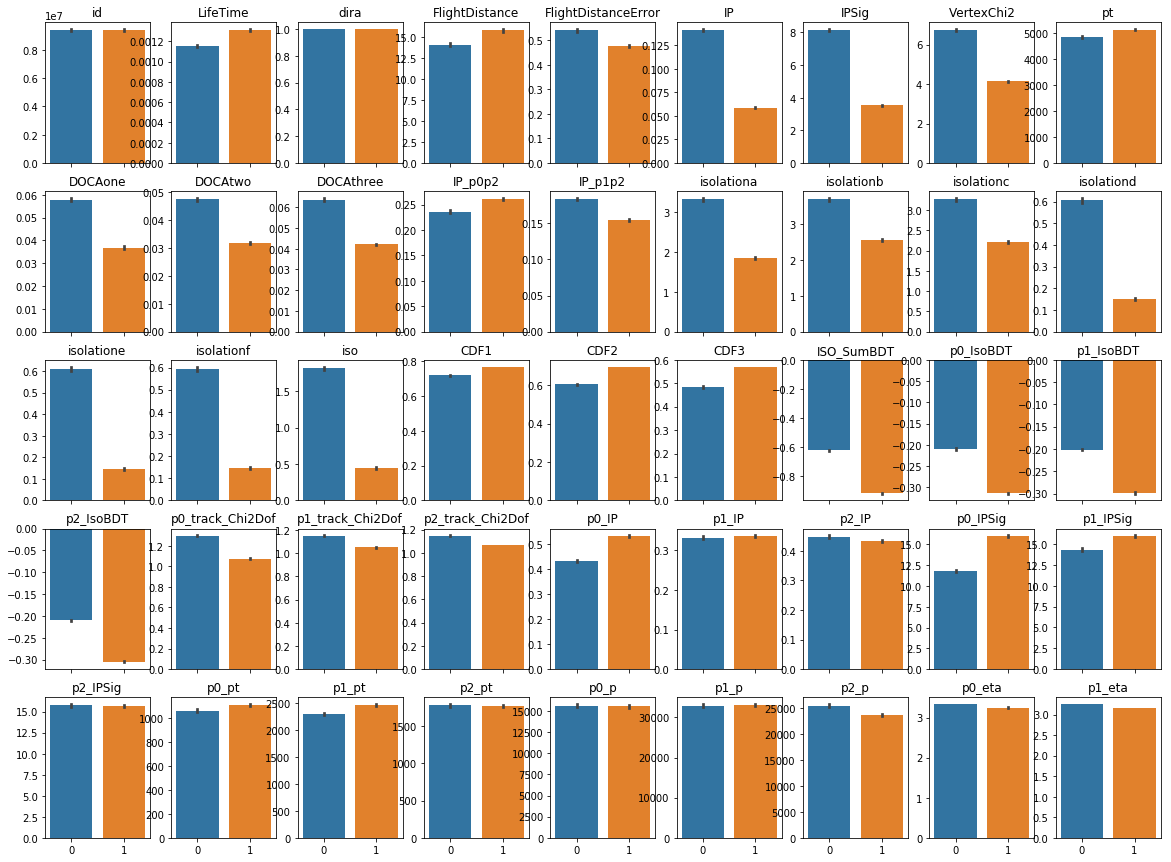

In [20]:
fig, ax = plt.subplots(nrows=5, ncols=9 ,figsize=(20,15), sharex=True)
start = 0
main_columns=[]
for i in training_dataset:
    main_columns.append(i)
for j in range(5):
    for i in range(9):
        if start == len(main_columns):
            break
        sns.barplot(y=main_columns[start], x='signal', data=training_dataset, ax=ax[j,i])
        ax[j,i].set_ylabel('')
        ax[j,i].set_xlabel('')
        ax[j,i].set_title(main_columns[start], fontsize=12)
        start += 1


See the correlation between signal and variables. Low correlation means low impact on determining if it is data or not, it can be usefull to remove variables with low correlation.

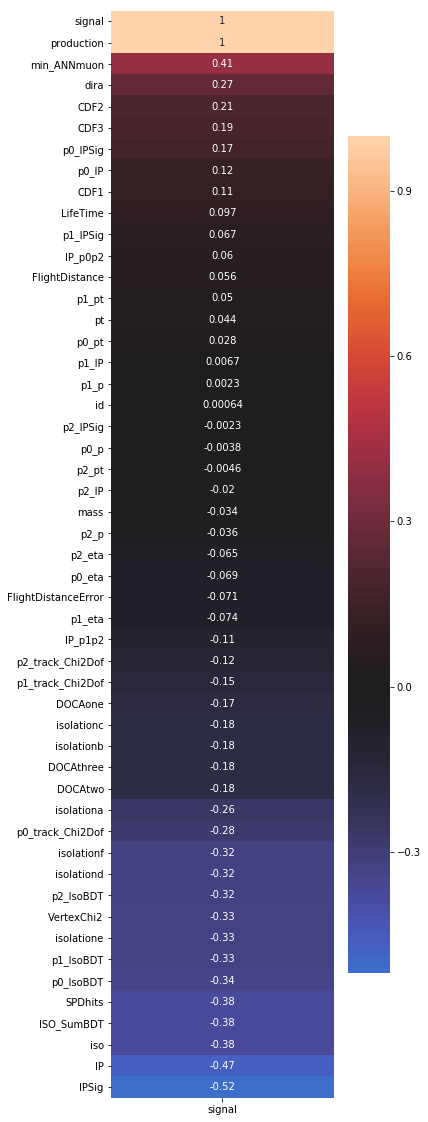

In [21]:
corr=training_dataset.corr()['signal']
plt.figure(figsize=(5,20))
sns.heatmap(corr.to_frame().sort_values(by="signal", ascending=False), annot=True, center=0)


(67553, 4)


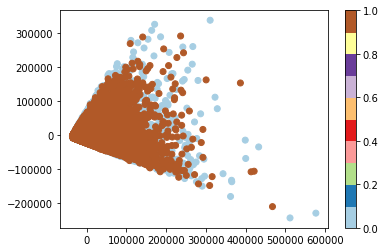

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
proj = pca.fit_transform(training_dataset)
print(proj.shape)
plt.scatter(proj[:, 1], proj[:, 2], c=training_dataset['signal'], cmap=plt.get_cmap('Paired', 10))
plt.plot()
plt.colorbar()

As we can see the datas are not clustered at all. It makes algorithm like k-neighbour not worth to test

We remove data with low correlation or low physics meaning from variables and we define the training dataset:

In [28]:
#print(abs(corr).to_frame().sort_values(by="signal", ascending=True))
train = pd.read_csv("/kaggle/working/training.csv", index_col='id')
variables=train.drop(["production", "min_ANNmuon","signal","mass","SPDhits","FlightDistanceError"],axis=1).columns
training_expected=contest_data['training.csv']['signal']
training_data=contest_data['training.csv'][variables] 
agreement_expected=contest_data["check_agreement.csv"]['signal']
agreement_data=contest_data['check_agreement.csv'][variables]


**First try with Gaussian Naive Bayes**

In [32]:
from sklearn.naive_bayes import GaussianNB
init=np.random.randint(1,311000)
confusion_matrix=[[0,0],[0,0]]
X_train, X_test, y_train, y_test = train_test_split(training_data, training_expected, random_state=init)
gnb = GaussianNB()
print(gnb.fit(X_train, y_train))

# use the model to predict the labels of the test data
predicted = gnb.predict(X_test)
expected = y_test.to_numpy()

#eval(gnb,variables)
for i in range(len(expected)):
    # label the image with the target value
    confusion_matrix[int(np.round(predicted[i]))][expected[i]]+=1
print("confusion matrix=",confusion_matrix)
print("Identification ratio:",(confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[1][1]+confusion_matrix[1][0]+confusion_matrix[0][1]))
if(check_corr_test(gnb,variables) and check_ag_test(gnb,variables)):
    candidate_models[gnb] = comp_auc(gnb,variables)
    print('passed')
else:
    print("failed")

GaussianNB(priors=None, var_smoothing=1e-09)
confusion matrix= [[3561, 1106], [2936, 9286]]
Identification ratio: 0.7606726271537687
CvM metric 0.0009740856618284466 True
KS metric 0.022227423253856515 True
AUC 0.7801000128221568
passed


Score can be improved by dropping some variables, both Agreement and Correlation tests are passed

In [33]:
init=np.random.randint(1,311000)
clf=LinearDiscriminantAnalysis()
X_train, X_test, y_train, y_test = train_test_split(training_data, training_expected, random_state=init)
print(clf.fit(X_train, y_train))

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
expected = y_test.to_numpy()

print("Score = ",clf.score(X_train, y_train))

# split the data into training and validation sets
#XP_train, XP_test, yP_train, yP_test = train_test_split(training_dataset, training_dataset['signal'], random_state=init)
#confusion matrix
confusion_matrix=[[0,0],[0,0]]
for i in range(len(expected)):
    # label the image with the target value
    confusion_matrix[int(predicted[i])][expected[i]]+=1
print(confusion_matrix)




predicted = clf.predict(X_test)
expected = y_test.to_numpy()
confusion_matrix=[[0,0],[0,0]]
for i in range(len(expected)):
    # label the image with the target value
    confusion_matrix[int(np.round(predicted[i]))][expected[i]]+=1
print("confusion matrix=",confusion_matrix)
print("Identification ratio:",(confusion_matrix[0][0]+confusion_matrix[1][1])/(confusion_matrix[0][0]+confusion_matrix[1][1]+confusion_matrix[1][0]+confusion_matrix[0][1]))
if(check_corr_test(clf,variables) and check_ag_test(clf,variables)):
    candidate_models[clf] = comp_auc(clf,variables)
    print('passed')
else:
    print("failed")

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Score =  0.83828754144955
[[4803, 1071], [1599, 9416]]
confusion matrix= [[4803, 1071], [1599, 9416]]
Identification ratio: 0.8419089348096395
CvM metric 0.0011840922317621295 True
KS metric 0.021678803873749652 True
AUC 0.8508783177330428
passed


Both tests are once again passed. Better area under ROC curve tha GNB

In [34]:
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.1, 'loss': 'ls'}
init=np.random.randint(300000)
#create data
X_train, X_test, y_train, y_test = train_test_split(training_data, training_expected, random_state=init)

score_agreement=[]
# create the model
clf = ensemble.GradientBoostingRegressor(**params)

#train data
clf.fit(X_train, y_train)

# use the model to predict the labels of the test data
predicted = clf.predict(X_test)
expected=y_test.values
agreement=y_train.values
agreement_predicted=clf.predict(agreement_data)
#score.append(clf.score(X_train, y_train))
score_agreement.append(clf.score(agreement_data,agreement_expected))
print(score_agreement)
confusion_matrix=[[0,0],[0,0]]
total=0
reussi=0
for i in range(0,len(predicted)):
    total+=1
    if int(np.round(predicted[i]))==expected[i]:
        reussi+=1
    # label the image with the target value
    confusion_matrix[int(np.round(predicted[i]))][expected[i]]+=1
print(confusion_matrix)
print(total,reussi,reussi/total)
if(check_corr_test_GBR(clf,variables) and check_ag_test_not_int(clf,variables)):
    candidate_models[clf] = comp_auc(clf,variables)
    
    print('passed')
else:
    print("failed")

[-6.898162132383694]
[[5245, 945], [1173, 9526]]
16889 14771 0.874592930309669
CvM metric 0.0009859844240452844 True
KS metric 0.6961851015601563 False
failed


Correlation test is passed but agreement is bad. Issue with overtraining?

In [35]:
#overtraining proof:
score=[]
score_agreement=[]
n_estimators=[]
agreement_test=[]
correlation_test=[]

for i in range(1,1001,100):

    params = {'n_estimators': i, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.2, 'loss': 'ls'}

# create the model
    clf = ensemble.GradientBoostingRegressor(**params)

    init=np.random.randint(300000)
#create data
    X_train, X_test, y_train, y_test = train_test_split(training_data, training_expected, random_state=init)

#train data
    clf.fit(X_train, y_train)
    
# use the model to predict the labels of the test data
    predicted = clf.predict(X_test)
    agreement_predicted=clf.predict(agreement_data)
    score.append(clf.score(X_train, y_train))
    score_agreement.append(clf.score(agreement_data,agreement_expected))
    n_estimators.append(i)
    agreement_test.append(check_ag_test_get_value(clf,variables))
    correlation_test.append(check_corr_test_get_value_GBR(clf,variables))
    
print(n_estimators, score,score_agreement)

[1, 101, 201, 301, 401, 501, 601, 701, 801, 901] [0.16126400085834747, 0.6397008022476548, 0.673437976896281, 0.6962033876696379, 0.714452415578526, 0.7348717352752375, 0.7526057886903826, 0.7702859099598202, 0.7835317996296124, 0.7951990449040092] [-12.45800530815162, -6.924657241129957, -7.042692666848886, -7.12001871970258, -7.2077098847238705, -7.6027522070120455, -7.213762378881359, -7.587339706920199, -6.801966995614097, -7.344431418702549]


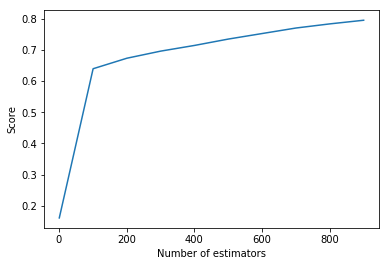

In [39]:
plt.plot(n_estimators, score)
plt.ylabel('Score')
plt.xlabel('Number of estimators')
plt.show()

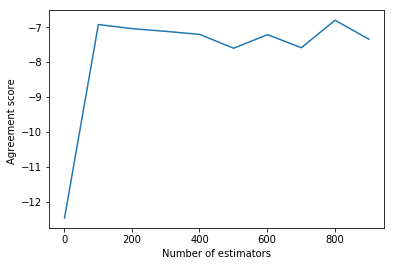

In [40]:
plt.plot(n_estimators, score_agreement)
plt.ylabel('Agreement score ')
plt.xlabel('Number of estimators')
plt.show()

In [36]:
print(correlation_test,agreement_test)

[0.0043477259512935094, 0.0010399346178855359, 0.0010587279171461253, 0.0009387934261624453, 0.0009666178125924674, 0.0008188274413241967, 0.0008348395372622385, 0.000901236919820145, 0.0010590056630265597, 0.0009347473048654614] [1.0, 0.6962612761162792, 0.6825086462828552, 0.6532575168620781, 0.6719655478690691, 0.6132778412902117, 0.653518953487736, 0.6445767676752567, 0.6311520914340736, 0.6432934882515049]


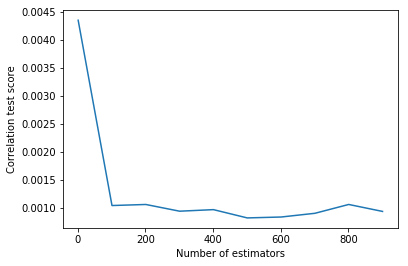

In [42]:
plt.plot(n_estimators, correlation_test)
plt.ylabel('Correlation test score')
plt.xlabel('Number of estimators')
plt.show()

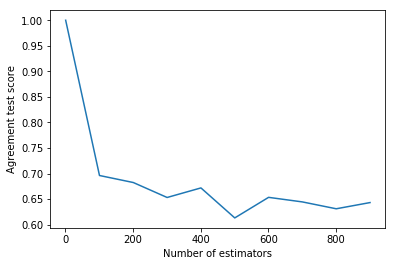

In [43]:
plt.plot(n_estimators, agreement_test)
plt.ylabel('Agreement test score')
plt.xlabel('Number of estimators')
plt.show()

It is hard to conclude on overtraining as the correlations are always too strong. 

These results have to be taken carefully: "predict_proba" makes GNB and LDA pass the correlation and the agreement test, but "predict" doesn't. As "predict_proba" doesn't exist for GBR, it can explain the fact that it does not pass the identification